# EE5907/EE5027 Programming Assignment CA1

> by: SUN Shuo A0162488U
> 
> "You may just run the code blocks all the way till the end"

## Data Processing

In [14]:
import scipy.io
import numpy as np

# Load mat data
mat_data = scipy.io.loadmat('data/spamData.mat')
#print(mat_data)
x_train = mat_data['Xtrain']
y_train = mat_data['ytrain']
x_test = mat_data['Xtest']
y_test = mat_data['ytest']

#x_train = np.array([(1,0), (1,1), (0,0)]).reshape(-1,2)
#y_train = np.array([1, 1, 0]).reshape(-1,1)
#x_test = np.array([(1,0), (1,0)]).reshape(-1,2)
#y_test = np.array([1, 1]).reshape(-1,1)

# Check data shapes and types
print("X train", type(x_train), "shape:", x_train.shape, "dtype:", x_train.dtype)
print("y train", type(y_train), "shape:", y_train.shape, "dtype:", y_train.dtype)
print("X test", type(x_test), "shape:", x_test.shape, "dtype:", x_test.dtype)
print("y test", type(y_test), "shape:", y_test.shape, "dtype:", y_test.dtype)

# Binarization 
x_train_bin = (x_train > 0) * 1
x_test_bin = (x_test > 0) * 1
#print(x_train_bin)
#print(x_test_bin)

# Log Transform
x_train_log = np.log(x_train + 0.1)
x_test_log = np.log(x_test + 0.1)
#print(x_train_log)
#print(x_test_log)

X train <class 'numpy.ndarray'> shape: (3065, 57) dtype: float64
y train <class 'numpy.ndarray'> shape: (3065, 1) dtype: uint8
X test <class 'numpy.ndarray'> shape: (1536, 57) dtype: float64
y test <class 'numpy.ndarray'> shape: (1536, 1) dtype: uint8


## Q1. Beta-binomial Naive Bayes (24%)

In [19]:
def beta(N, N_1, alpha):
    """
    Compute the Beta(`alpha`, `alpha`) distribution
    """
    if (N + 2*alpha) > 0:
        return (N_1 + alpha)/(N + 2*alpha)
    else:
        return 0

def featureLikelihood(X_train, Y_train, j, x_j, c, alpha):
    """
    Compute the feature likelihood term for one (x_test, y_test=c) data point
    Class: `c`, Feature: `j`: p(x_test_j| x_i_j, y_test=c)
    """
    N = (Y_train == c).sum()
    X_train_j = X_train[:, j].reshape(-1, 1)
    N_1 = (X_train_j[Y_train == c] == 1).sum()
    #print("N:", N, "N_1:", N_1)
    
    if x_j == 1:
        return beta(N, N_1, alpha)
    else:
        return 1 - beta(N, N_1, alpha)

def posteriorPredictiveDistribution(X_train, Y_train, X_test, i, c, alpha):
    """
    Compute the posterior predictive distribution of test feature
    SUM of log(p(x_test_j | x_i_j, y_test=c))
    """
    p_sum = 0
    # For its j-th feature
    for j in range(X_test.shape[1]):
        p = featureLikelihood(X_train, Y_train, j, X_test[i][j], c, alpha)
        if p > 0:
            p_sum += np.log(p)
        #print("Term(", i, ",", j, ") is:", p)
            
    return p_sum
    
def betaBinomialNaiveBayes(X_train, Y_train, X_test, alpha):
    """
    Fit a Beta Binomial Naive Bayes Classifier on the `X_train`, `Y_train` data,
    and predict the results `Y_pred` with the given `alpha`
    """
    # Class label prior lambda
    lambda_ml = (Y_train == 1).sum() / Y_train.shape[0]
    #print("lambda_ml:", lambda_ml)
    
    Y_pred = np.zeros((X_test.shape[0], 1), dtype=int)
    # For the i-th test data
    for i in range(Y_pred.shape[0]):
        P_0 = np.log(1 - lambda_ml) + posteriorPredictiveDistribution(X_train, Y_train, X_test, i, 0, alpha)
        P_1 = np.log(lambda_ml) + posteriorPredictiveDistribution(X_train, Y_train, X_test, i, 1, alpha)
        #print(P_0)
        #print(P_1)
        if P_0 < P_1:
            Y_pred[i][0] = 1
        #print(Y_pred)
        #print("y predict", type(Y_pred), "shape:", Y_pred.shape, "dtype:", Y_pred.dtype)
    
    return Y_pred

def computeErrorRate(X_train, Y_train, X_test, Y_test, alpha):
    """
    Compute the Error Rate based on the `Y_pred` result and the given ground truth `Y_test`, 
    with a given alpha values
    """
    Y_pred = betaBinomialNaiveBayes(X_train, Y_train, X_test, alpha)
    num_error = (Y_pred != Y_test).sum()
    return num_error/Y_test.shape[0]
    
def compareAlphas(X_train, Y_train, X_test, Y_test, alphas):
    """
    Compute the Error Rate based on the `Y_pred` result and the given ground truth `Y_test`, 
    with varying alpha values
    """
    error_rates = np.zeros((alphas.shape[0], 1))
    for i in range(alphas.shape[0]):
        error_rates[i] = computeErrorRate(X_train, Y_train, X_test, Y_test, alphas[i])
    return error_rates


### Compute and Plot Results

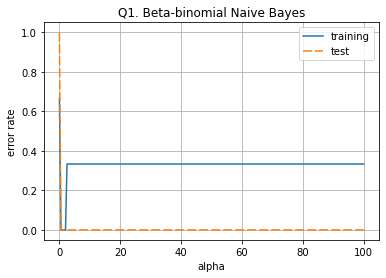

In [21]:
import matplotlib.pyplot as plt

# Set experimenting alpha values
alphas = np.arange(0, 100.5, 0.5)
train_error_rates = compareAlphas(x_train_bin, y_train, x_train_bin, y_train, alphas)
test_error_rates = compareAlphas(x_train_bin, y_train, x_test_bin, y_test, alphas)

# Plotting
fig, ax = plt.subplots()
line1, = ax.plot(alphas, train_error_rates, label='training')
line2, = ax.plot(alphas, test_error_rates, dashes=[6, 2], label='test')

ax.set(xlabel='alpha', ylabel='error rate', title='Q1. Beta-binomial Naive Bayes')
ax.legend()
ax.grid()

fig.savefig("pics/q1.png")
plt.show()

# Print some results
#print("On the training set, the error rates for α = 1, 10 and 100 are:", 
#      train_error_rates[2], train_error_rates[20], train_error_rates[-1])
#print("On the test set, the error rates for α = 1, 10 and 100 are:", 
#      test_error_rates[2], test_error_rates[20], test_error_rates[-1])

## Q2. Gaussian Naive Bayes (24%)

## Q3. Logistic regression (24%)

## Q4. K-Nearest Neighbors (24%)